In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare dataset where users are entity & books are features
### Read ratings data


In [2]:
ratings = pd.read_csv("data/ratings.csv")
n_users = ratings.user_id.unique().shape[0] # 53424 users
n_books = ratings.book_id.unique().shape[0] # 10000 books

In [3]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
print("The database contains ratings from", n_users, "users for", n_books, "books.")

The database contains ratings from 53424 users for 10000 books.


### Ceate user-book matrix of ratings

In [5]:
data_matrix = np.zeros((n_users, n_books))
for line in ratings.itertuples():
    # equivalent to user_id as row, book_id as col, ratings as values in the matrix
    data_matrix[line[2]-1, line[1]-1] = line[3]
print(type(data_matrix))

<class 'numpy.ndarray'>


### Explore how many books each user rates

In [7]:
user_row = 23 # set user row here, this will serve as argument in method

In [8]:
    n_books_rated = 0
    for book in range(0, n_books):
        if data_matrix[user_row, book] != 0:
            n_books_rated += 1
    print(n_books_rated)

17


In [9]:
np.count_nonzero(data_matrix[user_row])

17

### Split users who rated more than 50 books, i.e. 0.5% of 10k, to be considered as "recommender"
### & Save the rest of users, who did not rate many boosk, as "recommendee"

In [10]:
    # calculate how many books each of all users rated
    books_rated = np.zeros(n_users)
    for user in range(0, n_users):
        books_rated[user] = np.count_nonzero(data_matrix[user])

(array([17765., 11285.,  5856.,  3906.,  2768.,  2074.,  2969.,  1893.,
         1253.,  1595.,   866.,  1194.]),
 array([  0,   5,  10,  15,  20,  25,  30,  40,  50,  60,  80, 100, 200]),
 <a list of 12 Patch objects>)

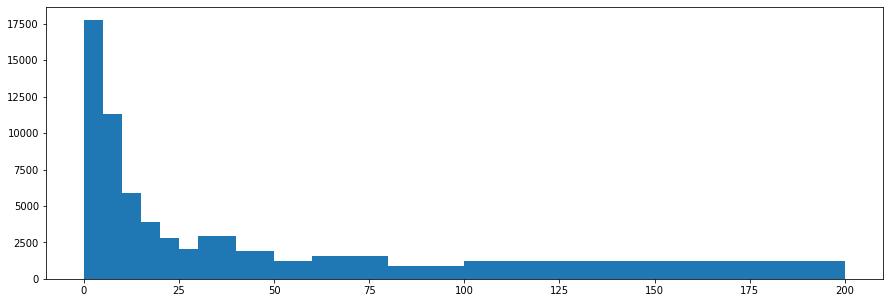

In [11]:
    plt.figure(figsize=(15,5))
    plt.hist(books_rated, bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 200])

In [12]:
    recommender = []
    recommendee = []
    for user in range(0, n_users):
        if np.count_nonzero(data_matrix[user]) > 50:
            recommender.append(data_matrix[user])
        else:
            recommendee.append(data_matrix[user])

In [13]:
    n_recommenders = len(recommender)
    n_recommendees = len(recommendee)
    print("split users to", n_recommenders, "recommenders and", n_recommendees, "recommendees")

split users to 4767 recommenders and 48657 recommendees


## Find cosine similarities between users

##### \begin{equation} cos(\pmb u, \pmb v) = \frac {\pmb u \cdot \pmb v}{||\pmb u|| \cdot ||\pmb v||} \end{equation}


### Calculate magnitude of vector

In [14]:
np.linalg.norm(recommender[0]) # in case of numpy array

33.689761055846034

In [15]:
def vector_magnitude(u):
    # u is 1d numpy array
    out = 0
    for j in range(1, len(u)):
        out += u[j]**2
    return math.sqrt(out)

In [16]:
vector_magnitude(recommender[0])

33.689761055846034

### Calculate dot product of two vectors

In [17]:
np.dot(recommender[2000], recommender[2000]) # in case of numpy array

887.0

In [18]:
def dot_product(u, v):
    out = 0
    for j in range(1, len(u)):
        out += u[j]*v[j]
    return out

In [19]:
dot_product(recommender[2000], recommender[2000])

887.0

### Calculate cosine similarity between two users, i.e. two vectors of each user ratings

In [20]:
def cos_similar(u, v):
    # return dot_product(u, v)/vector_magnitude(u)/vector_magnitude(v)
    ss_u = 0
    ss_v = 0
    enum = 0
    for j in range(1, len(u)):
        ss_u += (u[j]**2)
        ss_v += (v[j]**2)
        enum += u[j]*v[j]
    return enum/math.sqrt(ss_u)/math.sqrt(ss_v)

In [21]:
cos_similar(recommender[2000], recommender[2000]) # similarity of itself

0.9999999999999999

In [22]:
cos_similar(recommender[2000], recommender[2001]) # similarity to other

0.007188899706974858

### Find the k most similar recommenders of a given recommendee

In [24]:
recommendee_row = 23 # set user row here

In [25]:
    similar = np.zeros(n_recommenders)
    for user in range(0, n_recommenders):
        similar[user] = cos_similar(recommendee[recommendee_row], recommender[user])

In [26]:
print("This user read", np.count_nonzero(recommendee[recommendee_row]), "books.")
print("There are", np.count_nonzero(similar), "users that read at least one same book as this user.")

This user read 10 books.
There are 14 users that read at least one same book as this user.


(array([0., 0., 1., 7., 6., 0.]),
 array([0.005, 0.01 , 0.02 , 0.03 , 0.05 , 0.1  , 1.   ]),
 <a list of 6 Patch objects>)

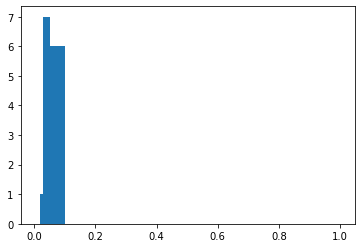

In [27]:
plt.hist(similar, bins = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 1])

In [28]:
max(similar) # the highest cosine similarity

0.06861170454139236

In [29]:
most_similar = np.where(similar == max(similar))[0][0] # the index of the most similar user (recommenders)
print(most_similar)

344


In [30]:
top_similar = np.where(similar > 0.05)[0] # top similar users
print(top_similar)

[  26  344  693 1494 4549 4744]


In [31]:
print("The most similar users/recommenders read", np.count_nonzero(recommender[most_similar]), "books.")
for user in top_similar:
    if user != most_similar:
        print("Other similar users/recommenders read", np.count_nonzero(recommender[user]), "books.")

The most similar users/recommenders read 54 books.
Other similar users/recommenders read 63 books.
Other similar users/recommenders read 52 books.
Other similar users/recommenders read 82 books.
Other similar users/recommenders read 74 books.
Other similar users/recommenders read 55 books.


## Find books highly rated by similar users
### Explore book ratings by k most similar users/recommenders

(array([ 1.,  3., 18., 20., 12.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

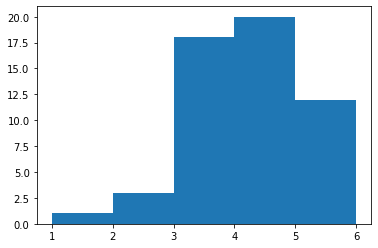

In [32]:
plt.hist(recommender[most_similar], bins = [1,2,3,4,5,6]) # still books with high ratings, still need to narrow down

### Applied weighted-average of book ratings among top similar users

(array([16.,  1.,  0.,  0.,  0.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

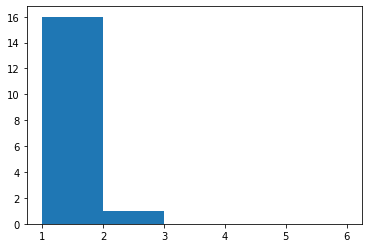

In [33]:
books_rating = np.zeros(n_books)
for user in top_similar:
    books_rating += recommender[user]/len(top_similar)
plt.hist(books_rating, bins = [1,2,3,4,5,6])

In [34]:
best_book = np.where(books_rating == max(books_rating))[0][0]
print(best_book)

4335


In [35]:
good_book = np.where(books_rating > 1)[0]
print(good_book)

[1495 1673 1799 2513 2925 2957 2968 3763 3798 4105 4335 4633 5729 9459]


### Read books data to match with book id

In [36]:
    books = pd.read_csv("data/books.csv")
    books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [37]:
books.loc[books['id']==best_book]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
4334,4335,5556466,5556466,5727588,52,312359322,9.780312e+12,John Hart,2009.0,The Last Child,...,22293,25587,3369,255,826,4458,10854,9194,https://images.gr-assets.com/books/1312058481m...,https://images.gr-assets.com/books/1312058481s...


In [38]:
books.loc[books['id'].isin(good_book)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
1494,1495,87640,87640,84604,7,60899190,9.780061e+12,Frank Warren,2005.0,PostSecret: Extraordinary Confessions from Ord...,...,58841,59379,1061,2911,3039,10287,17389,25753,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
1672,1673,18149927,18149927,21996351,38,NaN,NaN,Jodi Ellen Malpas,2013.0,Beneath This Man,...,44170,74457,3703,1532,2681,8933,19848,41463,https://images.gr-assets.com/books/1372773964m...,https://images.gr-assets.com/books/1372773964s...
1798,1799,8428064,8428064,11015791,46,1423121317,9.781423e+12,Rachel Hawkins,2011.0,Demonglass,...,74589,77626,4496,1036,2945,14055,26694,32896,https://images.gr-assets.com/books/1287692542m...,https://images.gr-assets.com/books/1287692542s...
2512,2513,10607,10607,1738813,104,034547063X,9.780345e+12,"Stephen King, Peter Straub",2001.0,Black House,...,40734,44826,1227,722,2405,9632,15995,16072,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
2924,2925,6534932,6534932,6727073,11,345518519,9.780346e+12,Kathy Griffin,2009.0,Official Book Club Selection: A Memoir Accordi...,...,31685,32718,1426,1304,2120,8243,11250,9801,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
2956,2957,121732,121732,877675,77,6280838,9.780006e+12,C.S. Lewis,1955.0,Surprised by Joy: The Shape of My Early Life,...,33698,35986,1156,612,1261,6142,12367,15604,https://images.gr-assets.com/books/1381407473m...,https://images.gr-assets.com/books/1381407473s...
2967,2968,833710,833710,1726608,46,743437314,9.780743e+12,D.J. MacHale,2002.0,The Merchant of Death,...,38633,40104,1723,1135,2545,8772,13355,14297,https://images.gr-assets.com/books/1351196725m...,https://images.gr-assets.com/books/1351196725s...
3762,3763,331319,331319,6170936,139,451527704,9.780452e+12,"Theodore Dreiser, Richard R. Lingeman",1925.0,An American Tragedy,...,25665,26988,956,752,1697,5683,9246,9610,https://images.gr-assets.com/books/1309283443m...,https://images.gr-assets.com/books/1309283443s...
3797,3798,11100431,11100431,16022532,19,316187712,9.780316e+12,Michael J. Sullivan,2012.0,Heir of Novron,...,25185,28151,1507,119,344,2314,8956,16418,https://images.gr-assets.com/books/1307960132m...,https://images.gr-assets.com/books/1307960132s...
4104,4105,84144,84144,81234,35,749935871,9.780750e+12,Sherrilyn Kenyon,2004.0,Seize the Night,...,29053,39269,1209,148,594,4920,13034,20573,https://images.gr-assets.com/books/1348418164m...,https://images.gr-assets.com/books/1348418164s...
